# Survival Analysis 
Survival analysis is used for modeling and analyzing survival rate (likely to survive) and hazard rate (likely to die).

<a name='1'></a>
## 1. Import Packages

In [58]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter

<a name='2'></a>
## 2. Loading the datasets
Data Description: We use 3 datasets. Clin_patients is clinical data about patients such as age, race, survival time and status, clin_samples includes information about the tumor sample, such as tumor subtype, site, tumor mutational burden, etc. The cluster_assignments are the obtained clusters from DEC.


In [60]:
clin_patients = pd.read_csv('./data/clinical_patients.csv')

In [61]:
clin_samples = pd.read_csv('./data/clinical_primary_raw.csv')

In [62]:
clin = pd.merge(clin_patients, clin_samples)

In [63]:
clin_samples

,SAMPLE_ID,PATIENT_ID,ORGAN_SYSTEM,ONCOTREE_CODE,SUBTYPE,SUBTYPE_ABBREVIATION,SAMPLE_TYPE,PRIMARY_SITE,METASTATIC_SITE,GENE_PANEL,...,DMETS_DX_ADRENAL_GLAND,DMETS_DX_KIDNEY,DMETS_DX_BLADDER_UT,DMETS_DX_FEMALE_GENITAL,DMETS_DX_OVARY,DMETS_DX_MALE_GENITAL,DMETS_DX_SKIN,DMETS_DX_HEAD_NECK,DMETS_DX_BREAST,TMB_NONSYNONYMOUS
0,P-0000520-T01-IM3,P-0000520,Core GI,COAD,Colorectal MSS,CRC MSS,Primary,Cecum,NaN,IMPACT341,...,No,No,Yes,No,No,Yes,No,No,No,5.545777
1,P-0000625-T01-IM3,P-0000625,Core GI,COAD,Colorectal MSS,CRC MSS,Primary,Cecum,NaN,IMPACT341,...,No,No,No,No,Yes,No,No,No,No,9.982398
2,P-0000674-T01-IM3,P-0000674,Core GI,READ,Colorectal MSS,CRC MSS,Primary,Rectum,NaN,IMPACT341,...,No,No,No,No,No,No,No,No,No,6.654932
3,P-0000678-T01-IM3,P-0000678,Core GI,COAD,Colorectal MSS,CRC MSS,Primary,Ascending Colon,NaN,IMPACT341,...,No,No,No,No,No,No,No,No,No,12.200708
4,P-0000695-T01-IM3,P-0000695,Core GI,COAD,Colorectal MSS,CRC MSS,Primary,Sigmoid Colon,NaN,IMPACT341,...,Yes,Yes,No,No,No,No,No,No,No,5.545777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068,P-0050459-T01-IM6,P-0050459,Core GI,COAD,Colorectal MSS,CRC MSS,Primary,Rectosigmoid Colon,NaN,IMPACT468,...,No,No,No,No,No,No,No,No,No,6.052887
2069,P-0050464-T01-IM6,P-0050464,Core GI,READ,Colorectal MSS,CRC MSS,Primary,Rectum,NaN,IMPACT468,...,No,No,No,No,No,No,No,No,No,8.646981
2070,P-0050491-T01-IM6,P-0050491,Core GI,COAD,Colorectal MSS,CRC MSS,Primary,Colon,NaN,IMPACT468,...,No,No,No,No,No,No,No,No,No,6.052887
2071,P-0050516-T01-IM6,P-0050516,Core GI,COAD,Colorectal MSS,CRC MSS,Primary,Colon,NaN,IMPACT468,...,No,No,No,No,No,No,No,No,No,6.917585


In [64]:
cluster_assignments = pd.read_csv('./results/DEC/dec_cluster_assignments_10.csv')  ##dec_cluster_assignments_5.csv for 5 clusters

In [65]:
cluster_assignments.patient_id = cluster_assignments.patient_id.str[:9]

In [66]:
data = pd.merge(cluster_assignments, clin, left_on=  ['patient_id'],
                   right_on= ['PATIENT_ID'])
data = data.rename(columns={"OS_MONTHS": "time", "OS_STATUS": "status"})

In [67]:
data.loc[data.status == "0:LIVING", "dead"] = 0 
data.loc[data.status == "1:DECEASED", "dead"] = 1
print("data shape: {}".format(data.shape))

data shape: (1801, 54)


In [68]:
data = data.dropna(subset=["time", "dead"])

In [69]:
data

,patient_id,cluster,PATIENT_ID,SEX,RACE,time,status,AGE_AT_EVIDENCE_OF_METS,AGE_AT_SEQUENCING,AGE_AT_DEATH,...,DMETS_DX_KIDNEY,DMETS_DX_BLADDER_UT,DMETS_DX_FEMALE_GENITAL,DMETS_DX_OVARY,DMETS_DX_MALE_GENITAL,DMETS_DX_SKIN,DMETS_DX_HEAD_NECK,DMETS_DX_BREAST,TMB_NONSYNONYMOUS,dead
0,P-0000520,6,P-0000520,Male,White,60.58,0:LIVING,62.98,66.63,NaN,...,No,Yes,No,No,Yes,No,No,No,5.545777,0.0
1,P-0000625,6,P-0000625,Female,Black or african american,5.22,1:DECEASED,68.80,69.77,70.20,...,No,No,No,Yes,No,No,No,No,9.982398,1.0
2,P-0000674,4,P-0000674,Female,White,21.78,1:DECEASED,65.29,65.33,67.15,...,No,No,No,No,No,No,No,No,6.654932,1.0
3,P-0000678,8,P-0000678,Male,White,22.34,1:DECEASED,82.34,83.52,85.38,...,No,No,No,No,No,No,No,No,12.200708,1.0
4,P-0000695,6,P-0000695,Male,White,3.12,1:DECEASED,54.29,56.44,56.70,...,Yes,No,No,No,No,No,No,No,5.545777,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,P-0050459,3,P-0050459,Male,Other,10.64,0:LIVING,49.92,49.82,NaN,...,No,No,No,No,No,No,No,No,6.052887,0.0
1797,P-0050464,7,P-0050464,Male,Pt refused to answer,10.64,0:LIVING,74.91,74.95,NaN,...,No,No,No,No,No,No,No,No,8.646981,0.0
1798,P-0050491,7,P-0050491,Male,Black or african american,8.54,1:DECEASED,52.28,53.49,54.20,...,No,No,No,No,No,No,No,No,6.052887,1.0
1799,P-0050516,2,P-0050516,Male,White,10.61,0:LIVING,68.71,68.75,NaN,...,No,No,No,No,No,No,No,No,6.917585,0.0


The column `time` states how long the patient lived before they died or were censored.

The column `dead` says whether a death was observed or not. `dead` is 1 if the event is observed (i.e. the patient died) and 0 if data was censored.

<a name='3'></a>
## 3. Checking for batch effects

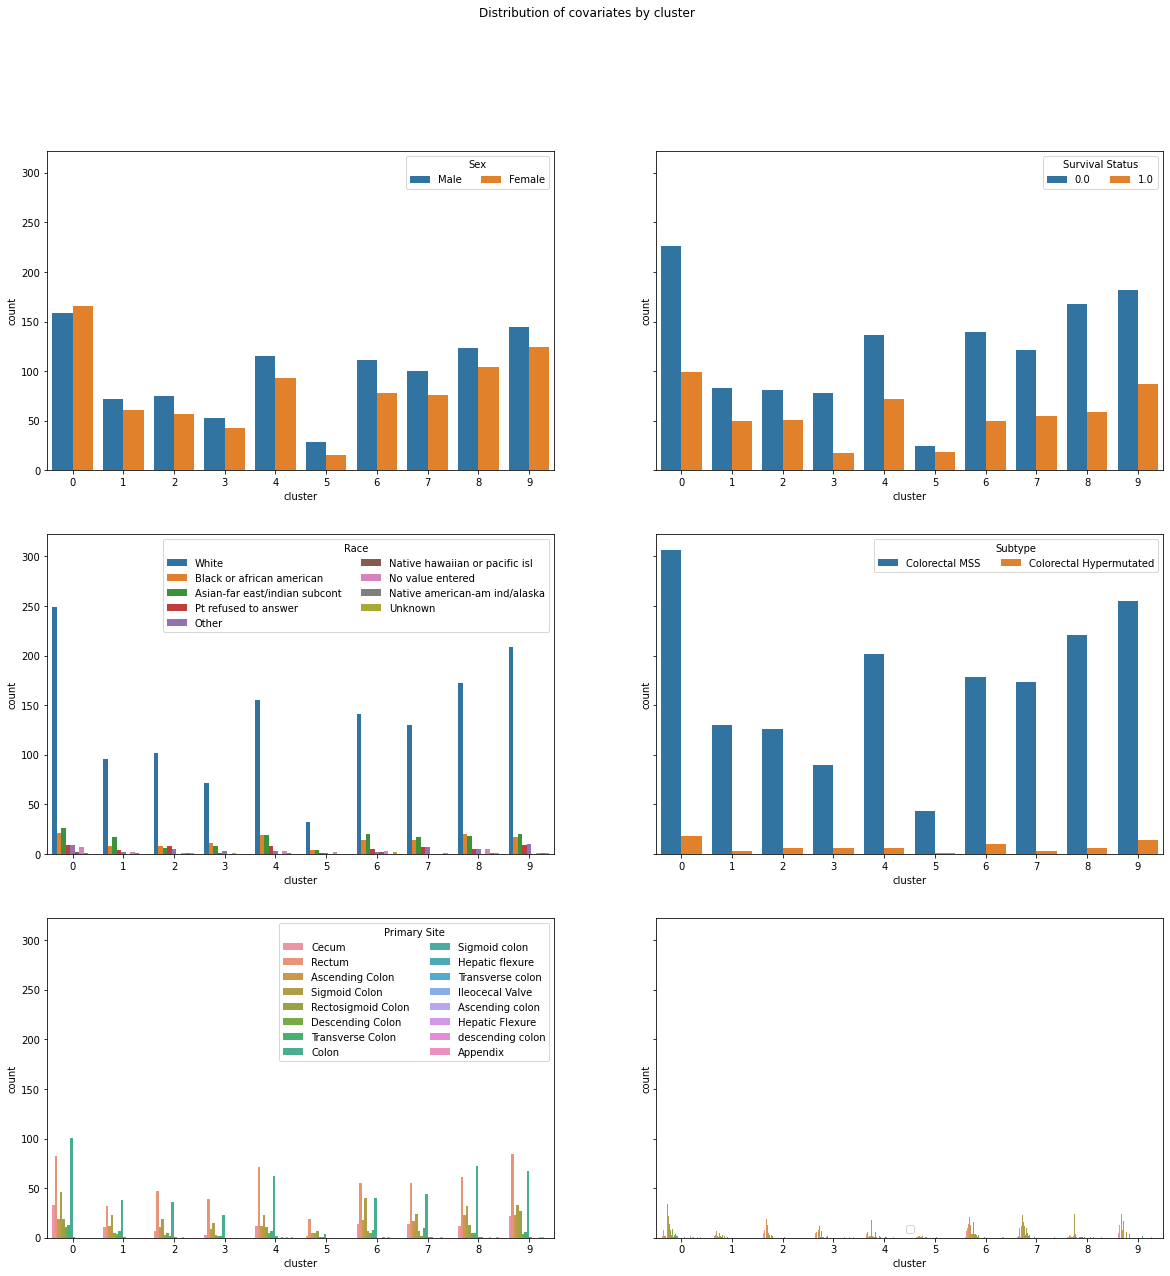

In [70]:
fig, axes = plt.subplots(3,2, figsize=(20, 20), sharey=True)
fig.suptitle('Distribution of covariates by cluster')

sns.countplot(ax = axes[0,0], data=data,x='cluster',hue='SEX')
axes[0,0].legend(title = "Sex", loc='upper right', ncol =2)

sns.countplot(ax = axes[0,1], data=data,x='cluster',hue='dead')
axes[0,1].legend(title = "Survival Status", loc='upper right', ncol =2)

sns.countplot(ax = axes[1,0], data=data,x='cluster',hue='RACE')
axes[1,0].legend(title = "Race", loc='upper right', ncol =2)

sns.countplot(ax = axes[1,1], data=data,x='cluster',hue='SUBTYPE')
axes[1,1].legend(title = "Subtype", loc='upper right', ncol =2)

sns.countplot(ax = axes[2,0], data=data,x='cluster',hue='PRIMARY_SITE')
axes[2,0].legend(title = "Primary Site", loc='upper right', ncol =2)

sns.countplot(ax = axes[2,1], data=data, x='cluster', hue='TMB_NONSYNONYMOUS')
axes[2,1].legend([])



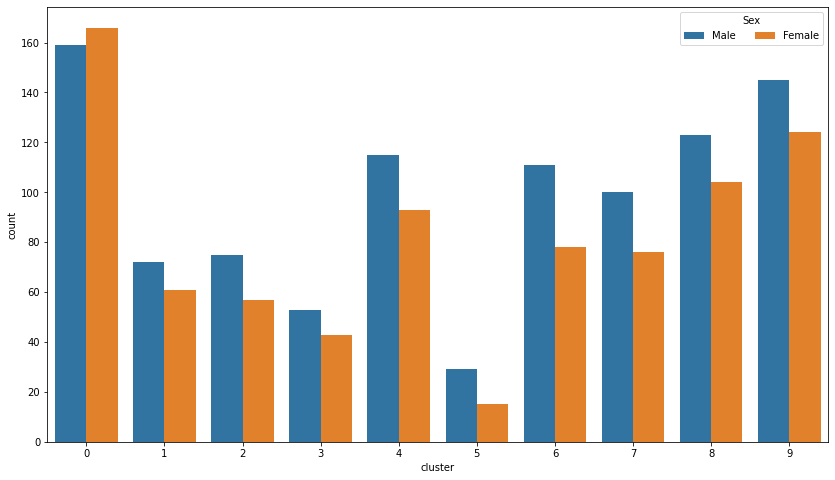

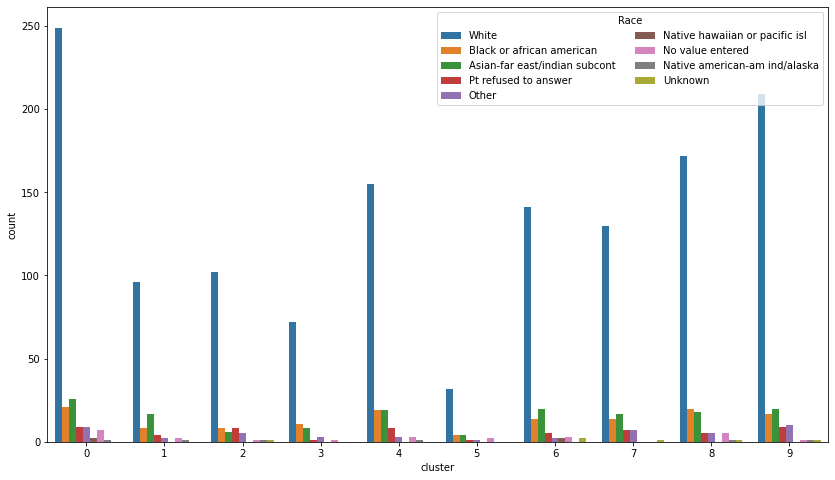

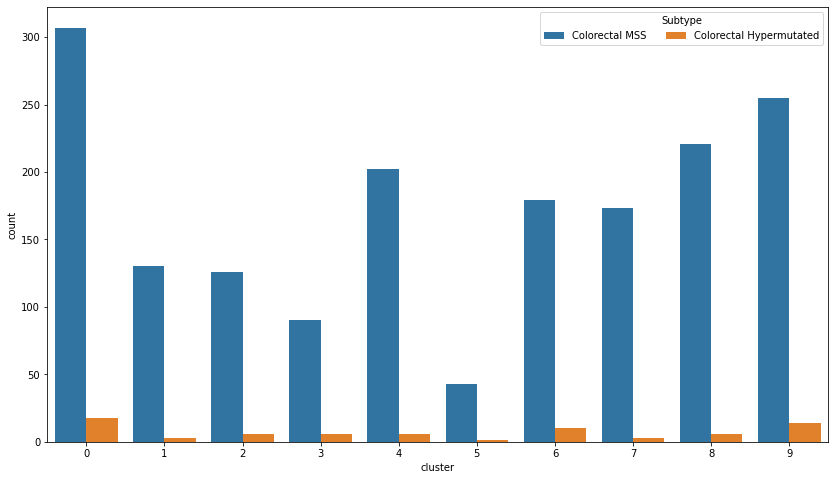

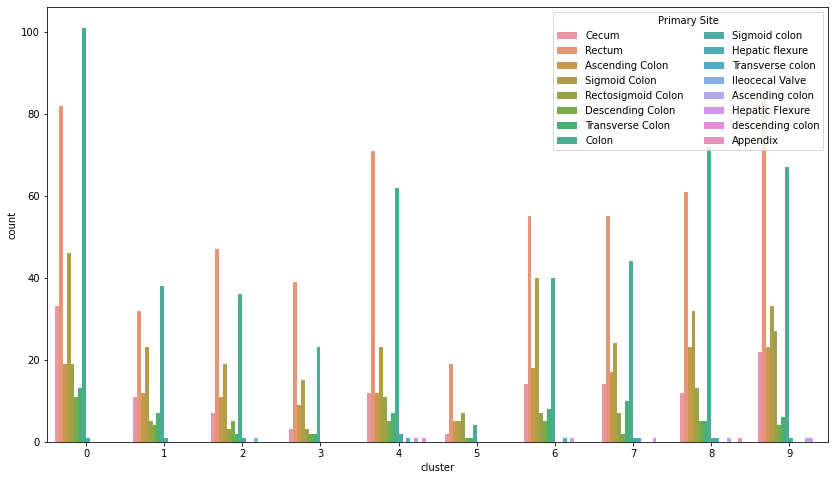

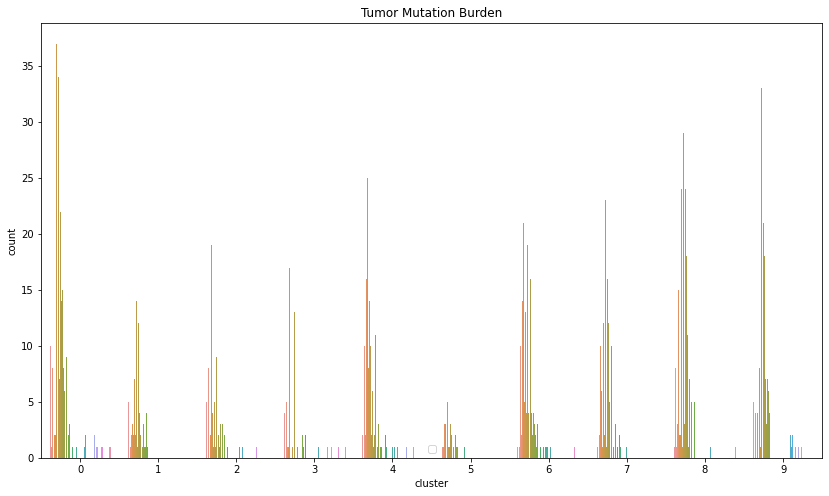

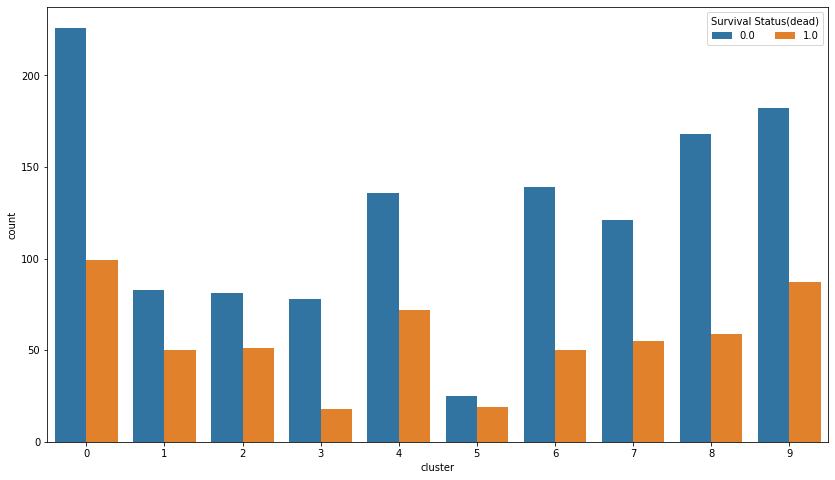

In [71]:
import seaborn as sns
plt.figure(figsize=(14,8))
sns.countplot(data=data,x='cluster',hue='SEX')
plt.legend(title = "Sex", loc='upper right', ncol =2)
plt.show()
plt.figure(figsize=(14,8))
sns.countplot(data=data,x='cluster',hue='RACE')
plt.legend(title = "Race", loc='upper right', ncol =2)
plt.show()
plt.figure(figsize=(14,8))
sns.countplot(data=data,x='cluster',hue='SUBTYPE')
plt.legend(title = "Subtype", loc='upper right', ncol =2)
plt.show()
plt.figure(figsize=(14,8))
sns.countplot(data=data,x='cluster',hue='PRIMARY_SITE')
plt.legend(title = "Primary Site", loc='upper right', ncol =2)
plt.show()
plt.figure(figsize=(14,8))
sns.countplot(data=data,x='cluster',hue='TMB_NONSYNONYMOUS')
plt.title("Tumor Mutation Burden")
plt.legend([])
plt.figure(figsize=(14,8))
sns.countplot(data=data,x='cluster',hue='dead')
plt.legend(title = "Survival Status(dead)", loc='upper right', ncol =2)
plt.show()


<a name='4'></a>
## 3. Survival Analysis

We can plot a histogram of the survival times to see in general how long cases survived before censorship or events.

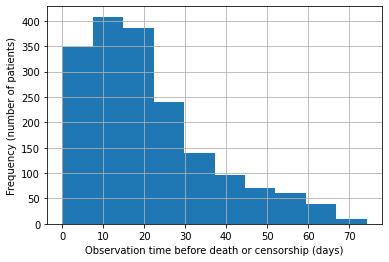

In [72]:
data.time.hist()
plt.xlabel("Observation time before death or censorship (days)")
plt.ylabel("Frequency (number of patients)");

### Kaplan-Meier Estimate
 Kaplan-Meier estimate:

$$
S(t) = \prod_{t_i \leq t} (1 - \frac{d_i}{n_i})
$$

where $t_i$ are the events observed in the dataset and $d_i$ is the number of deaths at time $t_i$ and $n_i$ is the number of people who we know have survived up to time $t_i$.


<a name='Ex-1'></a>
### Exercise 1 - Kaplan-Meier 

In [73]:
# def KaplanMeier(df):
#     """
#     Return KM estimate evaluated at every distinct
#     time (event or censored) recorded in the dataset.
#     Event times and probabilities should begin with
#     time 0 and probability 1.
    
#     Example:
    
#     input: 
    
#          Time  Censor
#     0     5       0
#     1    10       1
#     2    15       0
    
#     correct output: 
    
#     event_times: [0, 5, 10, 15]
#     S: [1.0, 1.0, 0.5, 0.5]
    
#     Args:
#         df (dataframe): dataframe which has columns for Time
#                           and Event, defined as usual.
                          
#     Returns:
#         event_times (list of ints): array of unique event times
#                                       (begins with 0).
#         S (list of floats): array of survival probabilites, so that
#                             S[i] = P(T > event_times[i]). This 
#                             begins with 1.0 (since no one dies at time
#                             0).
#     """
#     # individuals are considered to have survival probability 1
#     # at time 0
#     event_times = [0]
#     p = 1.0
#     S = [p]
    
#     ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
#     # get collection of unique observed event times
#     observed_event_times = pd.unique(df.time)
  
#     # sort event times
#     observed_event_times = np.sort(observed_event_times)
    
#     # iterate through event times
#     for t in observed_event_times:
  
#         # compute n_t, number of people who survive to time t
#         n_t = len(df) - len(df[(df.time <= t) & (df.dead == 1)])
  
#         # compute d_t, number of people who die at time t
#         d_t = len(df[(df.time == t) & (df.dead == 1)])
        
#         # update p
#         p = p*1-(d_t/n_t)
  
#         # update S and event_times (ADD code below)
#         # hint: use append
        
#         S.append(p)
#         event_times.append(t)
    
#     ### END CODE HERE ###
  
#     return event_times, S

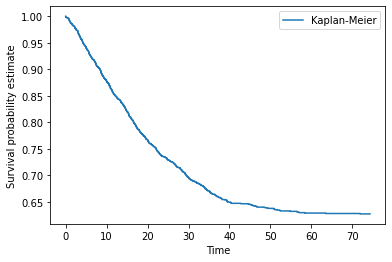

In [74]:
# x, y = KaplanMeier(data)
# plt.step(x, y, label="Kaplan-Meier")
# plt.xlabel("Time")
# plt.ylabel("Survival probability estimate")
# plt.legend()
# plt.show()

<AxesSubplot:xlabel='timeline'>

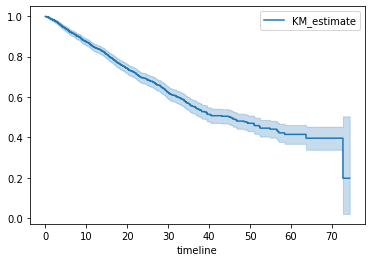

In [75]:
##KM function from lifelines package
km0 = KM()
km0.fit(data.loc[:, 'time'], event_observed = data.loc[:, 'dead'])
km0.plot() 


### Kaplan-Meier Estimate per cluster

Here we plot KM curves for each cluster and perform pairwise log rank tests to obtain clusters with significantly different survival patterns.


In [76]:
from lifelines.statistics import logrank_test

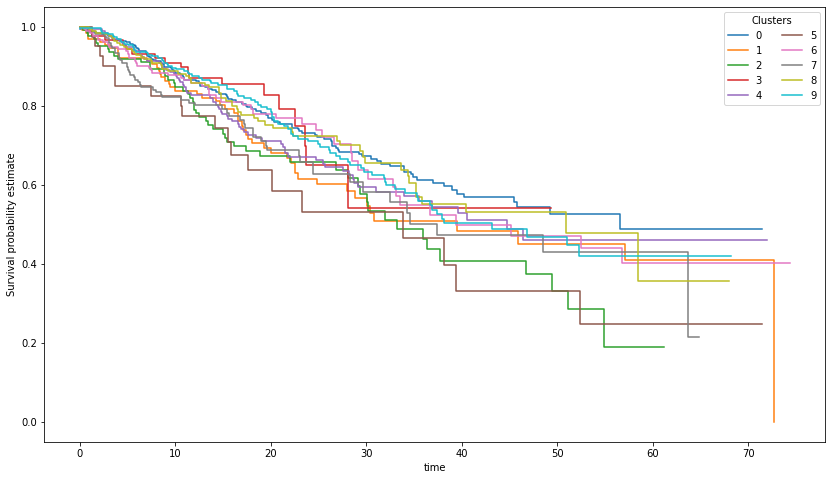

In [81]:
plt.figure(figsize=(14,8))
res_dict = {}
for i in range(0,10,1):
    S1 = data[data.cluster == i]
    km1 = KM()
    km1.fit(S1.loc[:, 'time'], event_observed = S1.loc[:, 'dead'], label = i)
    # j = i+1
    # S2 = data[data.cluster == j]
    # km2 = KM()
    # km2.fit(S2.loc[:, 'time'], event_observed = S2.loc[:, 'dead'], label = j)
    # ax = km1.plot(ci_show=False)
    km1.plot(ci_show=False)
    for j in range(0,10,1):
        if i != j and i < j:
            group1=data[data['cluster']==i]
            group2=data[data['cluster']==j]
            T=group1['time']
            E=group1['dead']
            T1=group2['time']
            E1=group2['dead']
            results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
            p_val = results.p_value
            res_dict[str(i)+"/"+str(j)] = p_val

plt.xlabel('time')
plt.ylabel('Survival probability estimate')  ##add difference significance measures
plt.legend(title = "Clusters", ncol = 2)
plt.savefig('two_km_curves', dpi=300)


In [88]:
{k for k, v in res_dict.items() if v < 0.1}

{'0/1', '0/2', '0/5', '0/7', '2/6', '2/8', '2/9', '3/5', '5/6', '5/8', '5/9'}